In [1]:
%run ../utils.py

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
import os.path as osp
import pickle
import numpy as np
import matplotlib.pyplot as plt
from cvutils import visualize
from imgaug import augmenters as iaa
import imgaug as ia
import keras
from cvutils.keras import generator as keras_generator
from cvutils.augmentation import imgaug as imgaug_utils
from cytokit_ml import losses as ml_losses
from cytokit_ml import augmentation as ml_augmentation
from cytokit_ml import metrics as ml_metrics
from cytokit.segmentation.models import unet_v1
import pandas as pd

seed = 8932
plt.gray()
init_session()

train_image_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'modeling', 'cytopy', 'datasets', 'kdsb2018', 'stage1_train')
data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'modeling', 'cytopy', 'datasets', 'kdsb2018', 'prep')
data_file = 'training_data_crop256_shrink8.pkl'
model_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'modeling', 'cytopy', 'models', 'nuclei', 'v0.3')
model_path = osp.join(model_dir, 'nuclei_model.h5')

In [3]:
with open(osp.join(data_dir, data_file), 'rb') as fd:
    data = pickle.load(fd)

In [4]:
data.keys()

dict_keys(['Y', 'class_names', 'index', 'meta', 'X'])

In [5]:
X, Y, class_names, index, meta = [data[k] for k in ['X', 'Y', 'class_names', 'index', 'meta']]

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype, index.shape

((1752, 256, 256, 1),
 dtype('uint8'),
 (1752, 256, 256, 5),
 dtype('bool'),
 (1752,))

In [7]:
input_shape = X.shape[1:]
input_shape

(256, 256, 1)

In [8]:
class_names

['bg', 'nuc_interior', 'nuc_boundary', 'nuc_partition', 'nuc_center']

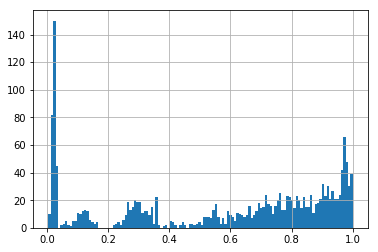

In [9]:
# Determine percent coverage of background in each image
bg_pcts = pd.Series([Y[i, ..., class_names.index('bg')].mean() for i in range(Y.shape[0])])
bg_pcts.hist(bins=128)

In [10]:
bg_mask = ((bg_pcts > .5) & (bg_pcts < 1.)).values
X, Y, index = X[bg_mask], Y[bg_mask], index[bg_mask]
X.shape, Y.shape, index.shape

((1091, 256, 256, 1), (1091, 256, 256, 5), (1091,))

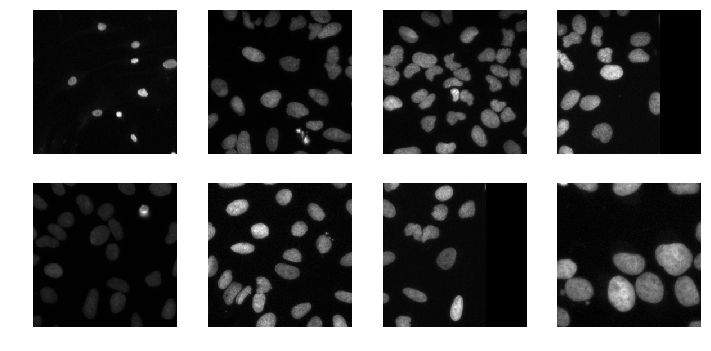

In [11]:
visualize.display_images([X[i, ..., 0] for i in range(0, 8)], size=12)

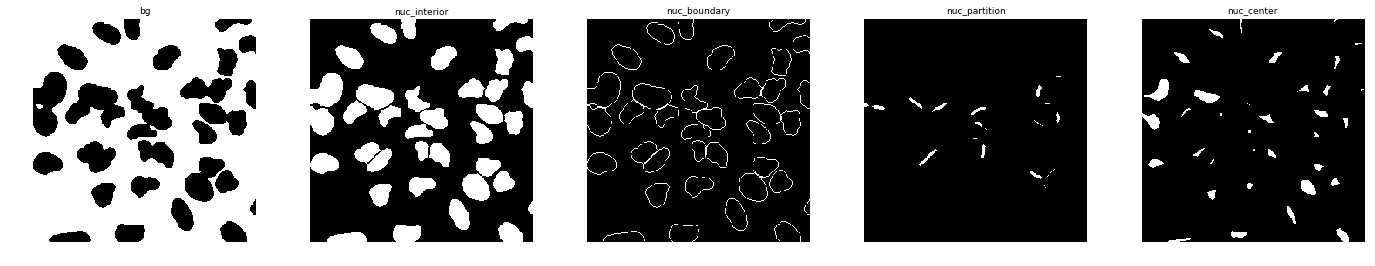

In [12]:
visualize.display_images([Y[2, ..., i] for i in range(Y.shape[-1])], cols=len(class_names), titles=class_names, size=24)

In [13]:
# Determine frequency of positive pixels by mask class
class_freq = np.apply_over_axes(np.mean, Y, axes=[0, 1, 2]).squeeze()
class_freq = pd.Series(dict(zip(class_names, class_freq)))
class_freq

bg               0.816516
nuc_boundary     0.018195
nuc_center       0.031687
nuc_interior     0.118800
nuc_partition    0.002741
dtype: float64

In [14]:
1/class_freq

bg                 1.224715
nuc_boundary      54.960932
nuc_center        31.558215
nuc_interior       8.417475
nuc_partition    364.815250
dtype: float64

In [15]:
# train_classes = ['nuc_interior', 'nuc_boundary', 'nuc_partition', 'nuc_center']
# train_class_wt = [1., 10., 50., 50.]
train_classes = ['nuc_interior', 'nuc_partition', 'nuc_center']

train_class_wt = [1., 30., 10.]

# pos_importance_factor = 50.
# train_class_wt = 1. / class_freq.loc[train_classes]
# train_class_wt /= train_class_wt.sum()
# train_class_wt = (pos_importance_factor * train_class_wt).round(2).tolist()

train_classes_idx = [class_names.index(c) for c in train_classes]
batch_size = 32

assert len(train_class_wt) == len(train_classes)
n_classes = len(train_classes)
Y_target = Y[..., train_classes_idx]
Y.shape, Y_target.shape, train_class_wt

((1091, 256, 256, 5), (1091, 256, 256, 3), [1.0, 30.0, 10.0])

In [16]:
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(np.arange(X.shape[0]), test_size=.2, random_state=seed)
X_train, X_test, Y_train, Y_test = X[idx_train], X[idx_test], Y_target[idx_train], Y_target[idx_test]

# X_train = X_train[:(batch_size * 8)]
# Y_train = Y_train[:(batch_size * 8)]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((872, 256, 256, 1),
 (219, 256, 256, 1),
 (872, 256, 256, 3),
 (219, 256, 256, 3))

In [36]:
import imp
imp.reload(unet_v1)

<module 'cytokit.segmentation.models.unet_v1' from '/lab/repos/cytokit/python/pipeline/cytokit/segmentation/models/unet_v1.py'>

In [37]:
#model = unet_v1.get_model(n_classes, input_shape, 'sigmoid', conv_activation=lambda l: keras.layers.LeakyReLU(alpha=.3)(l))
model = unet_v1.get_model(n_classes, input_shape, 'sigmoid', p=[4, 5, 6, 7, 8], conv_activation=lambda l: keras.layers.Activation('elu')(l))

In [38]:
optimizer = keras.optimizers.RMSprop(lr=1e-3)
metrics = [keras.metrics.binary_accuracy]
loss = ml_losses.objective_weighted_binary_crossentropy([[train_class_wt]])

for i, c in enumerate(train_classes):
    metrics.append(ml_metrics.binary_channel_precision(i, c, min_p=.5))
model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [39]:
import imp
imp.reload(ml_augmentation)
augmentation = ml_augmentation.get_augmentation_pipeline_01()

In [40]:
# visualize_augmentation(list(load_images(train_image_dir).values())[0], augmentation, 11, cols=4, size=20)

In [41]:
def pre_network_processor(sample_id, X, Y):
    # Convert image to standardized floats for network
    assert X.dtype == np.uint8
    assert Y.dtype == np.bool
    X = (X/255.).astype(np.float32)
    Y = Y.astype(np.float32)
    return X, Y

train_loader = imgaug_utils.InMemoryDataLoader(X_train, Y_train, augmentation=augmentation, processor=pre_network_processor)
test_loader = imgaug_utils.InMemoryDataLoader(X_test, Y_test, augmentation=None, processor=pre_network_processor)

train_generator = keras_generator.BaseDataGenerator(train_loader.ids, train_loader.load, batch_size=batch_size, shuffle=True)
test_generator = keras_generator.BaseDataGenerator(test_loader.ids, test_loader.load, batch_size=batch_size, shuffle=True)

In [42]:
# ex_aug = 'ex2'
# visualize_segmentation_augmentation(
#     X[index == DEFAULT_IDS[ex_aug]][0],
#     Y_target[index == DEFAULT_IDS[ex_aug]][0],
#     augmentation, n=5, size=30
# )

In [43]:
assert model_dir
!rm $model_dir/* || true

callbacks = [
    keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss', mode='min', verbose=0, 
        save_best_only=True, save_weights_only=False, period=1
    ), 
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=0, mode='min'), 
    keras.callbacks.TensorBoard(log_dir=model_dir),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, mode='min')
]

history = model.fit_generator(
    train_generator, 
    epochs=75,
    #steps_per_epoch=15,
    callbacks=callbacks,
    validation_data=test_generator
)

Epoch 1/75
28/28 [==============================] - 11s 402ms/step - loss: 0.7601 - binary_accuracy: 0.7451 - nuc_interior: 0.4390 - nuc_partition: 0.0468 - nuc_center: 0.1462 - val_loss: 0.6332 - val_binary_accuracy: 0.8764 - val_nuc_interior: 0.7097 - val_nuc_partition: 0.0118 - val_nuc_center: 0.1961
Epoch 2/75
28/28 [==============================] - 7s 265ms/step - loss: 0.7056 - binary_accuracy: 0.8473 - nuc_interior: 0.6389 - nuc_partition: 0.0747 - nuc_center: 0.2233 - val_loss: 0.5888 - val_binary_accuracy: 0.9075 - val_nuc_interior: 0.8549 - val_nuc_partition: 0.0131 - val_nuc_center: 0.2381
Epoch 3/75
28/28 [==============================] - 9s 325ms/step - loss: 0.6676 - binary_accuracy: 0.8710 - nuc_interior: 0.7002 - nuc_partition: 0.1010 - nuc_center: 0.2630 - val_loss: 0.5506 - val_binary_accuracy: 0.9224 - val_nuc_interior: 0.8479 - val_nuc_partition: 0.0123 - val_nuc_center: 0.2896
Epoch 4/75
28/28 [==============================] - 9s 317ms/step - loss: 0.6286 - bina

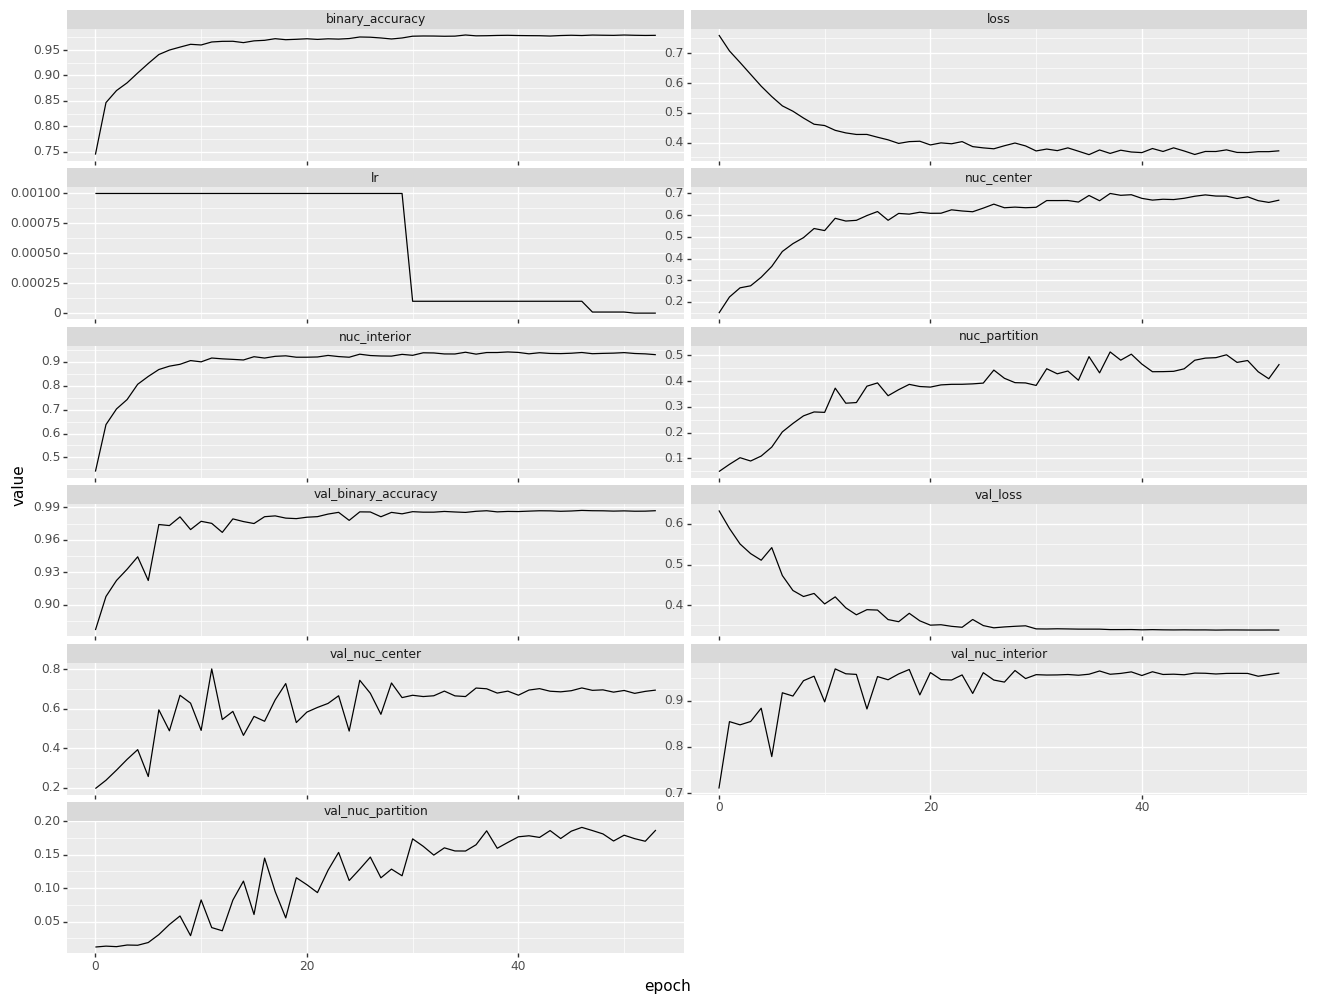

<ggplot: (8742649367542)>

In [44]:
visualize_model_history(history.history, window=slice(None, None))

In [45]:
pred_model = model

In [46]:
def inference_data(ids):
    mask = np.in1d(index, ids)
    Xi, Yi = X[mask], Y_target[mask]
    loader = imgaug_utils.InMemoryDataLoader(Xi, Yi, augmentation=None, processor=pre_network_processor)
    gen = keras_generator.BaseDataGenerator(loader.ids, loader.load, batch_size=len(Xi), shuffle=True)
    return gen[0]

inf_ids = [
    'a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288',
    '0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1',
    '07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5',
    '20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f',
    '5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3',
    '8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842',
    '547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6',
    'c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932',
    'cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490',
    '6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622'
]
X_pred, Y_true = inference_data(inf_ids)
X_pred.shape, Y_true.shape

((63, 256, 256, 1), (63, 256, 256, 3))

In [166]:
#pred_batch = train_batches
X_pred, Y_true = test_generator[1]
#X_pred, Y_true = train_generator[0]

In [47]:
Y_pred = pred_model.predict(X_pred)

In [48]:
X_pred.shape, Y_pred.shape, Y_true.shape

((63, 256, 256, 1), (63, 256, 256, 3), (63, 256, 256, 3))

In [49]:
X_pred.min(), X_pred.max()

(0.0, 1.0)

In [50]:
Y_pred.min(), Y_pred.max()

(0.26901105, 0.9998272)

In [32]:
# plt.hist(Y_pred.ravel(), bins=248)
# ax = plt.gca()
# ax.set_yscale('symlog')
# None

In [51]:
train_classes

['nuc_interior', 'nuc_partition', 'nuc_center']

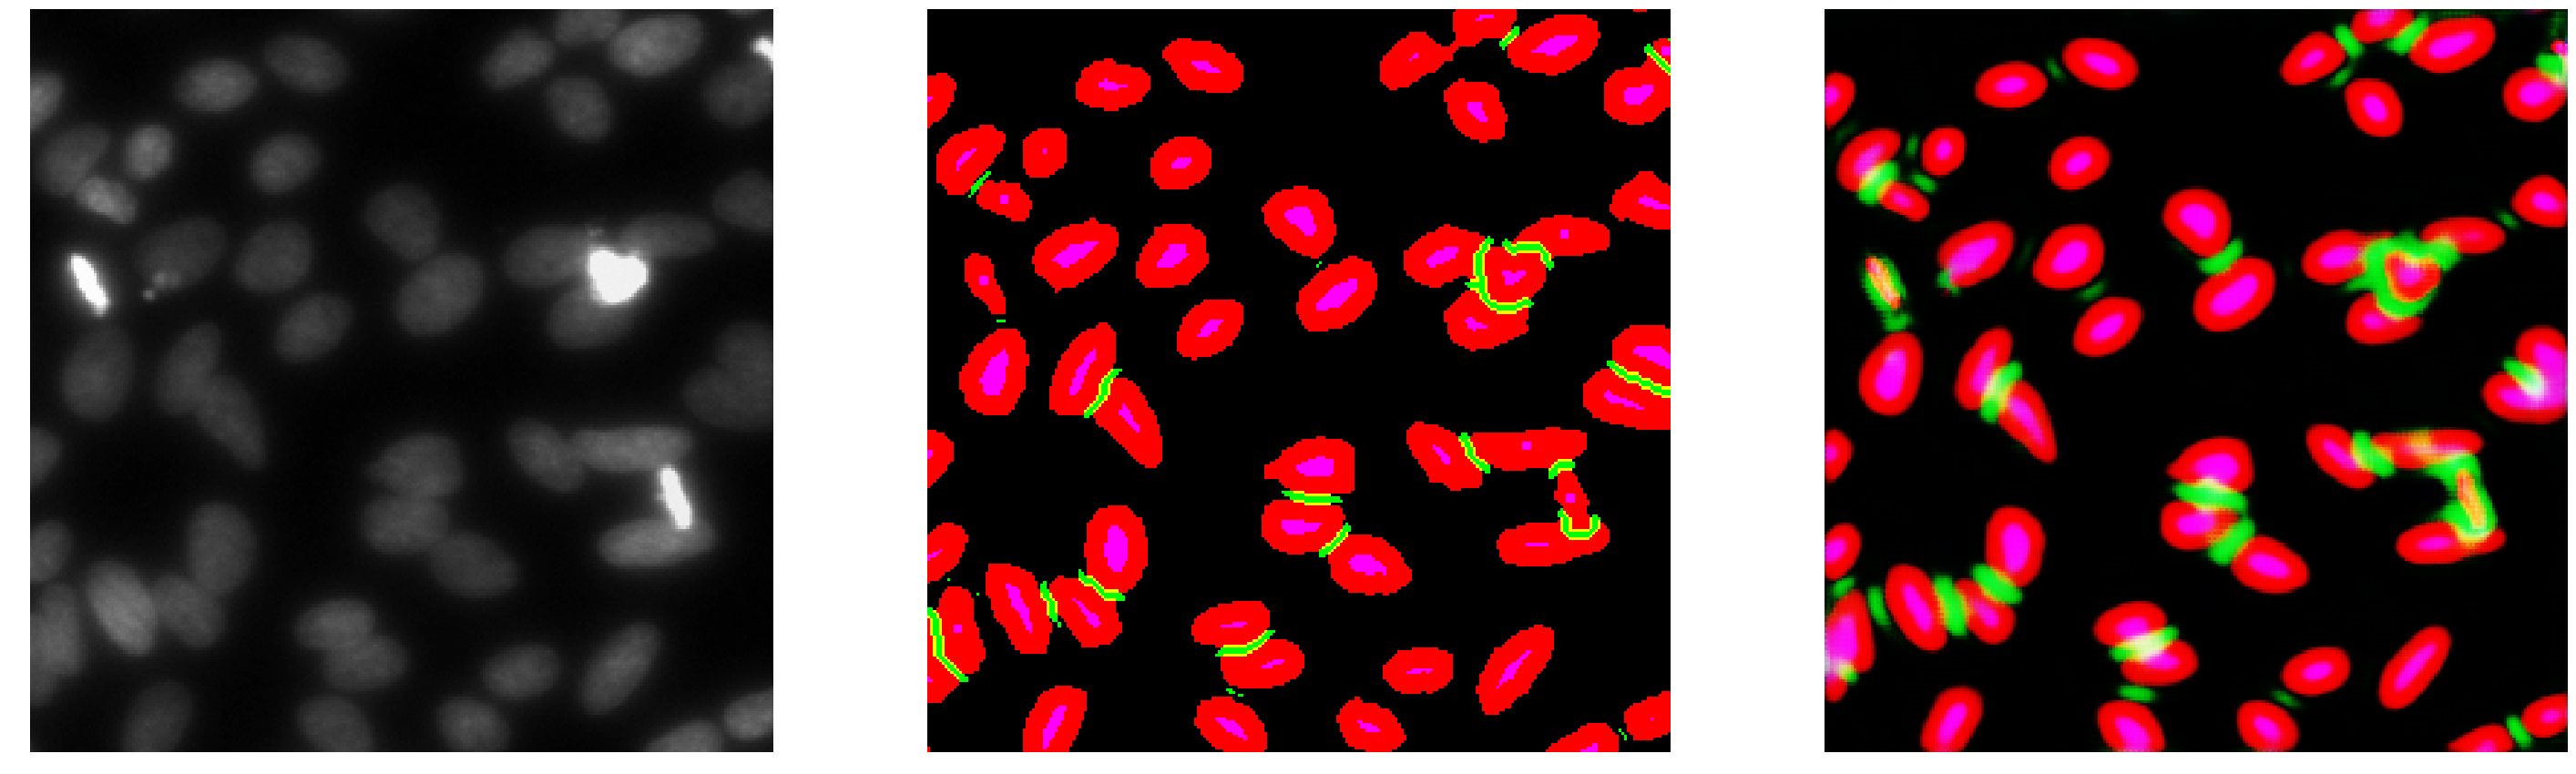

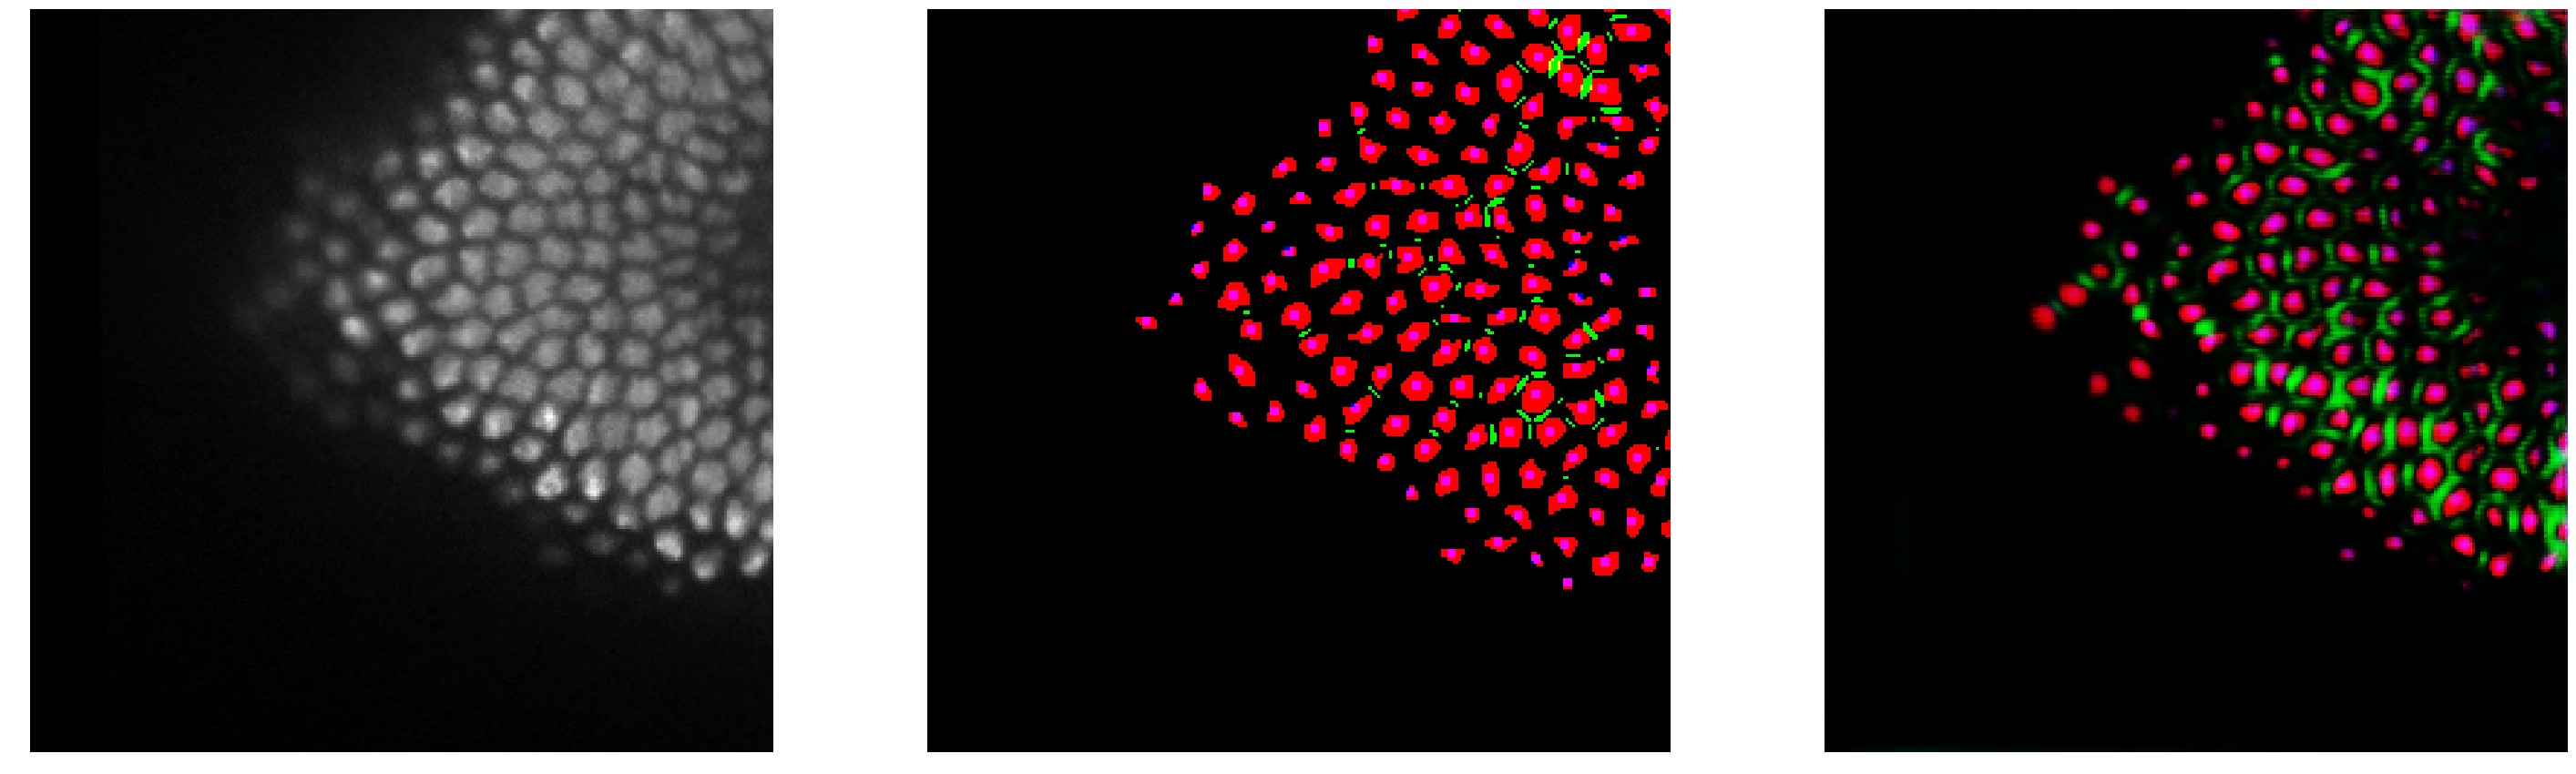

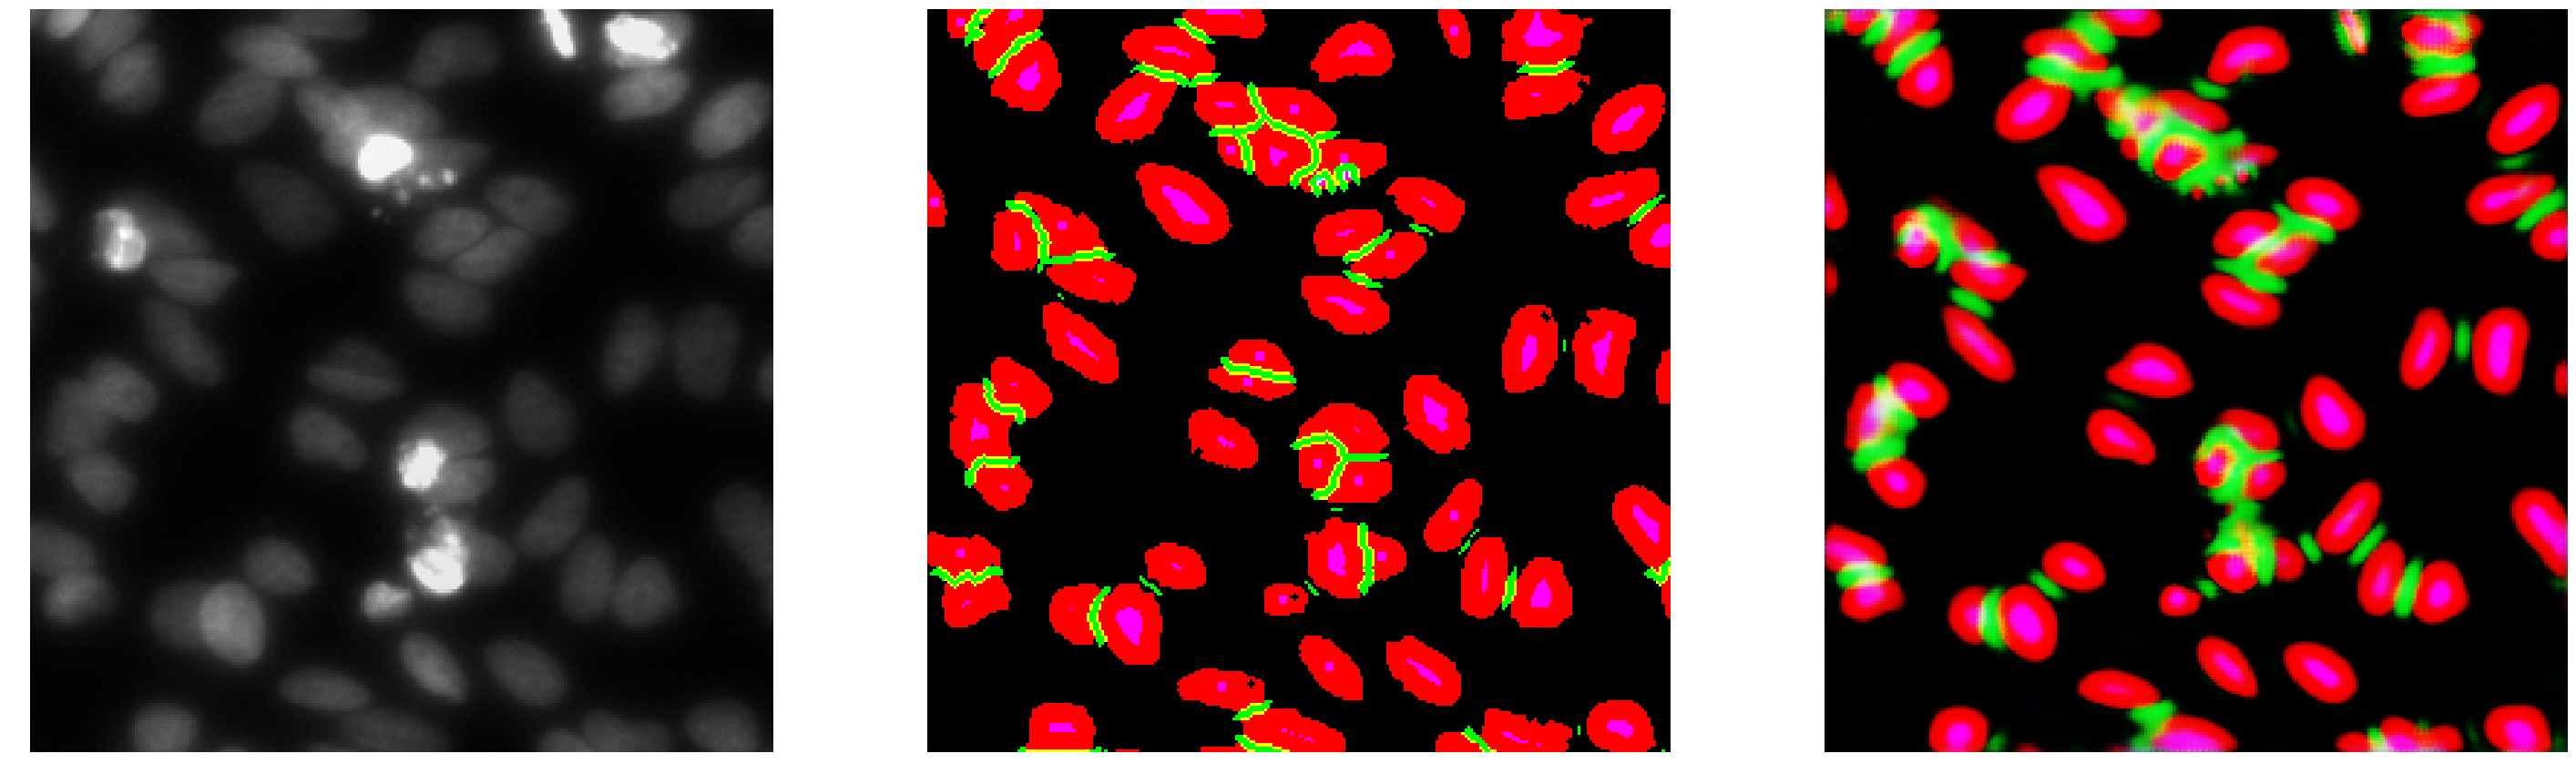

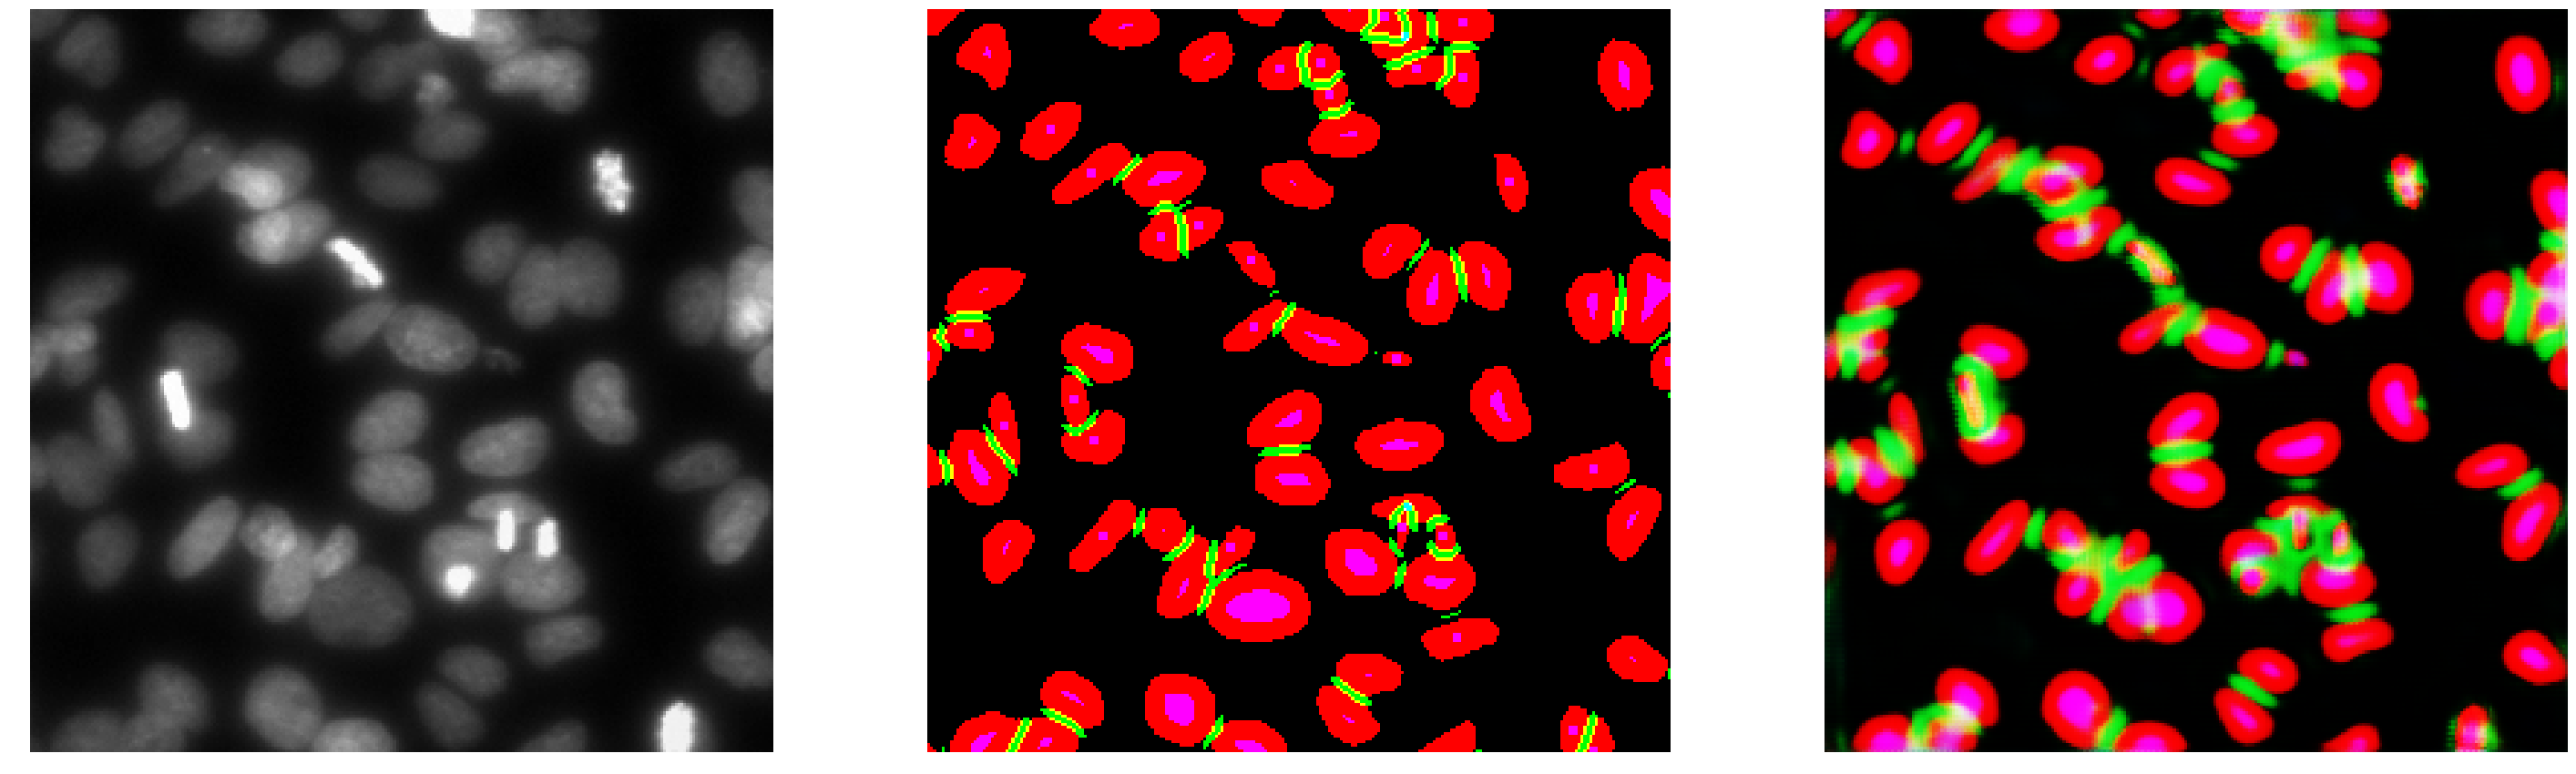

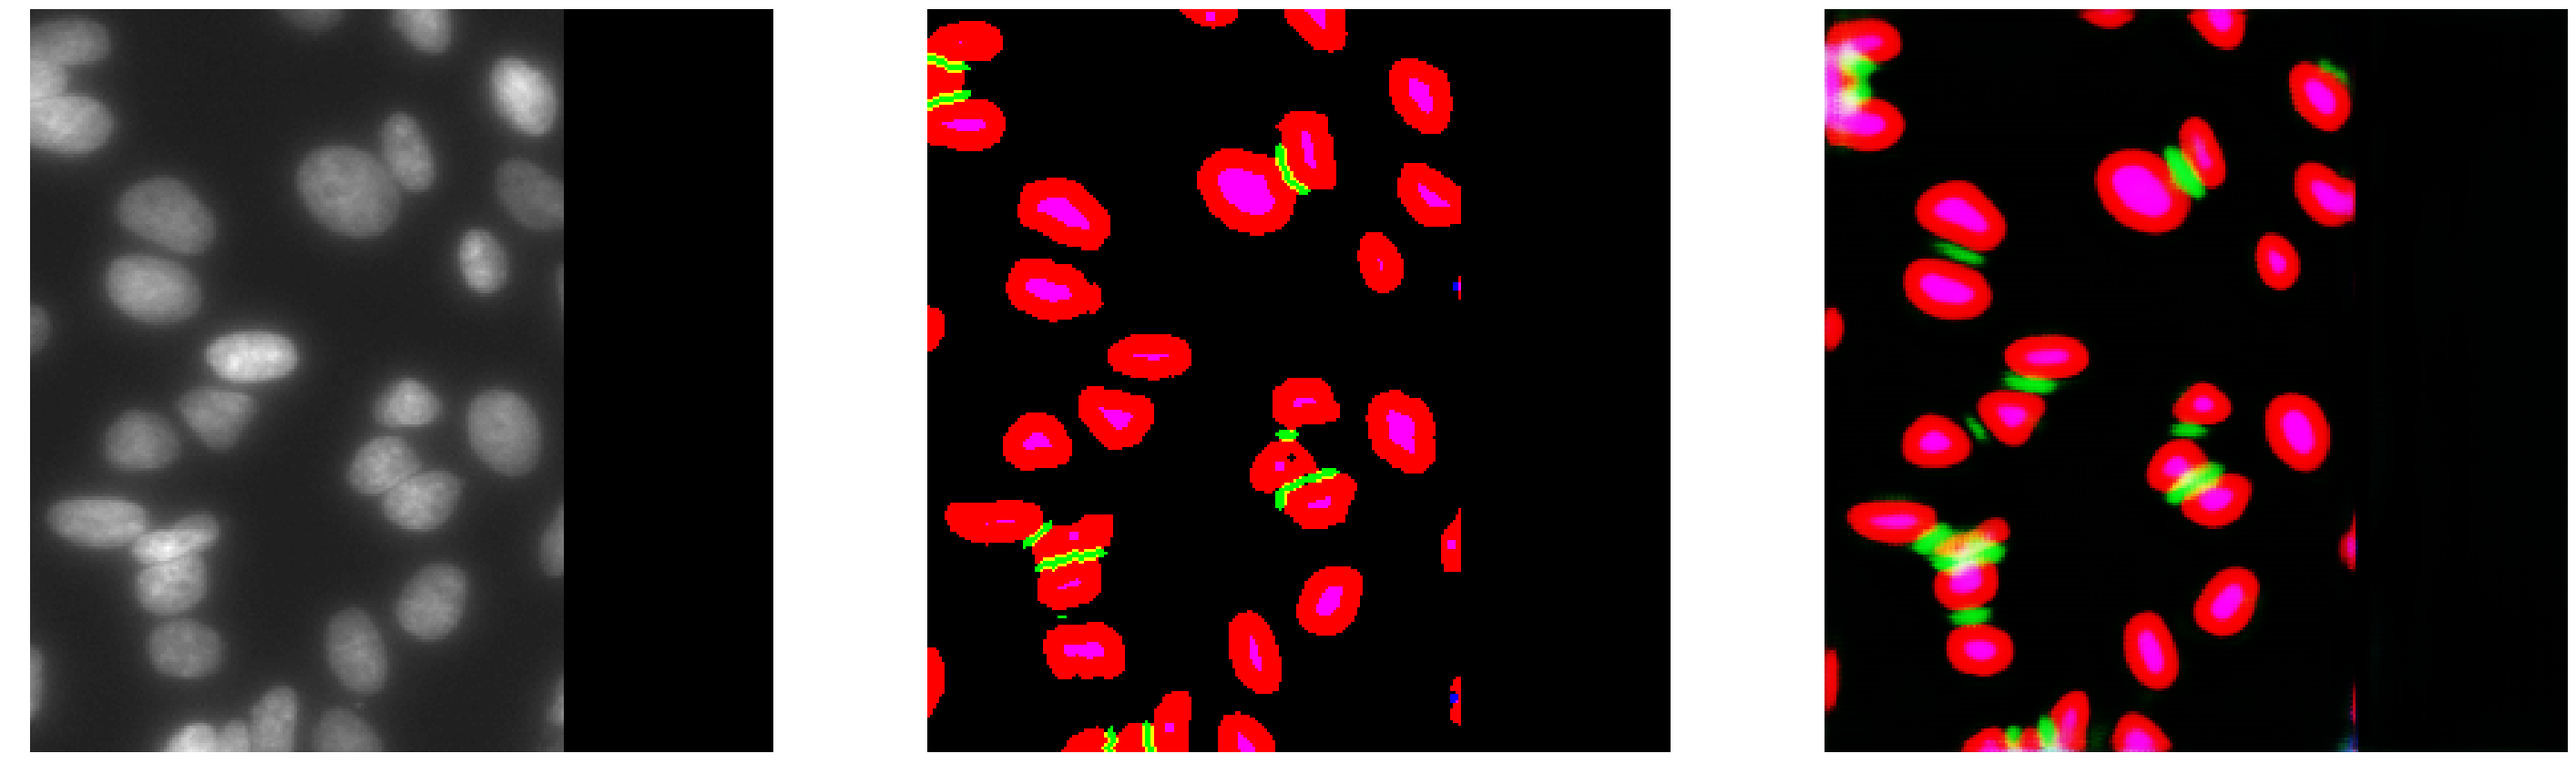

In [52]:
from skimage import exposure
y_chs = [0, 1, 2]
assert len(y_chs) == 3
viz_idx = np.random.choice(np.arange(len(X_pred)), replace=False, size=min(5, len(X_pred)))
#viz_idx = [0, 1, 2, 3, 4, 5]
#viz_idx = [0, 1, 2]
for i in viz_idx:
    images = []
    images += [exposure.rescale_intensity(X_pred[i, ..., 0], out_range=np.uint8).astype(np.uint8)]
    images += [exposure.rescale_intensity(Y_true[i][..., y_chs], out_range=np.uint8).astype(np.uint8)]
    images += [np.stack([
        exposure.rescale_intensity(Y_pred[i][..., yi], out_range=np.uint8).astype(np.uint8)
        for yi in y_chs
    ], -1)]
    visualize.display_images(images, size=50, cols=3)

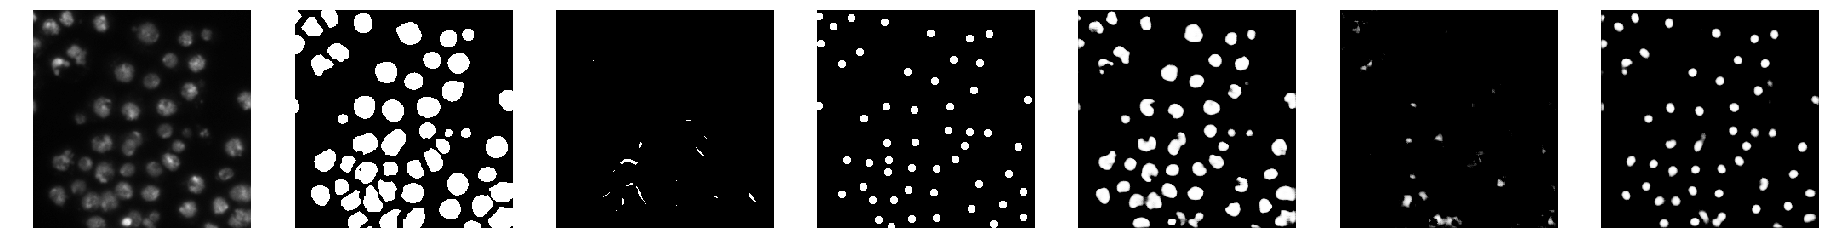

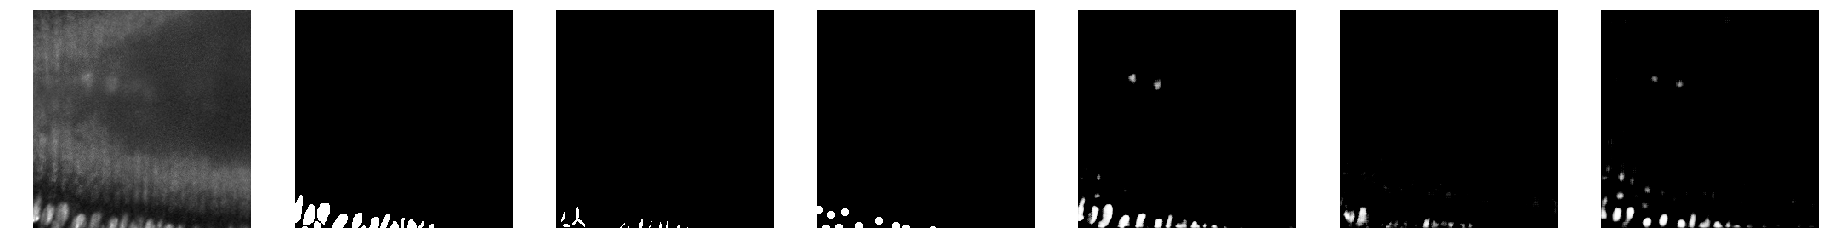

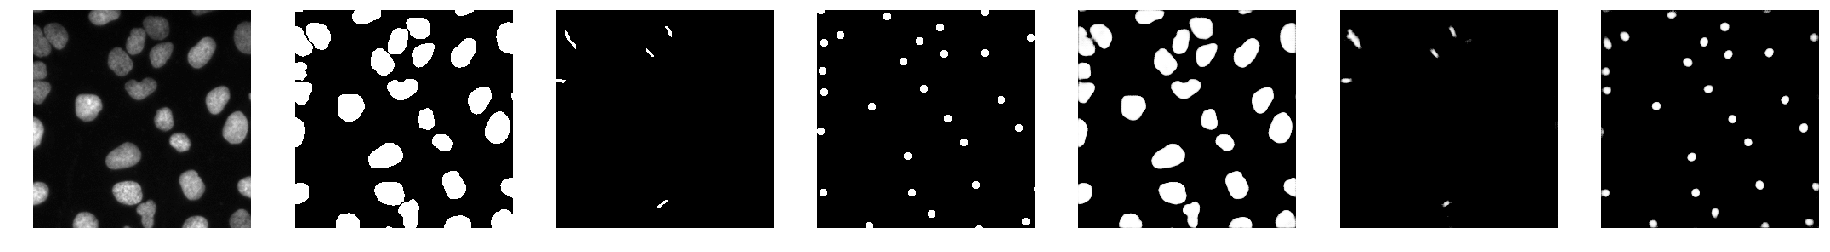

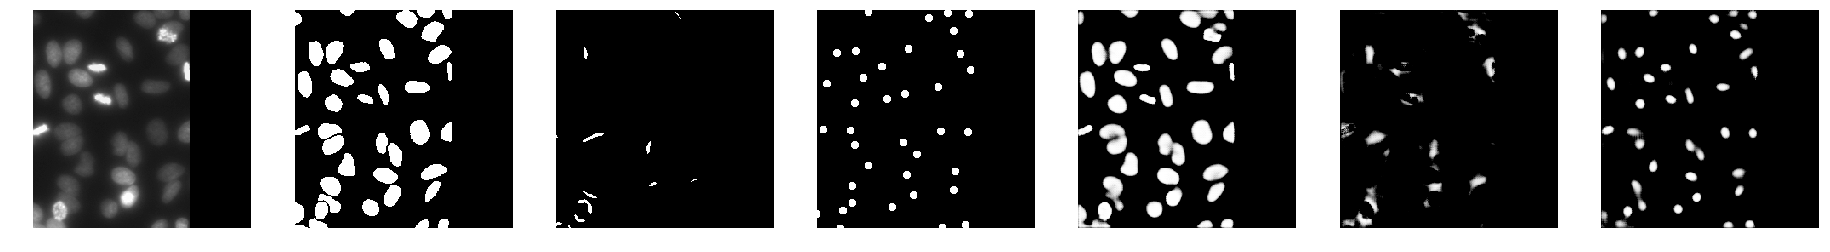

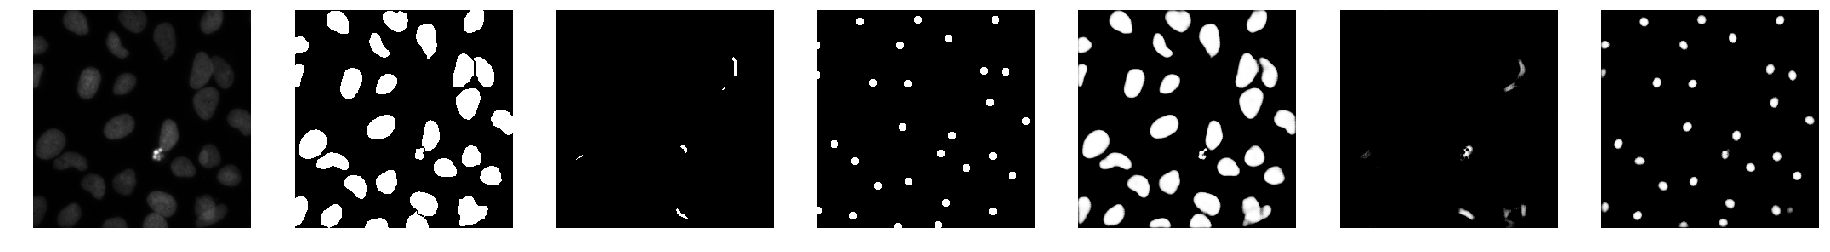

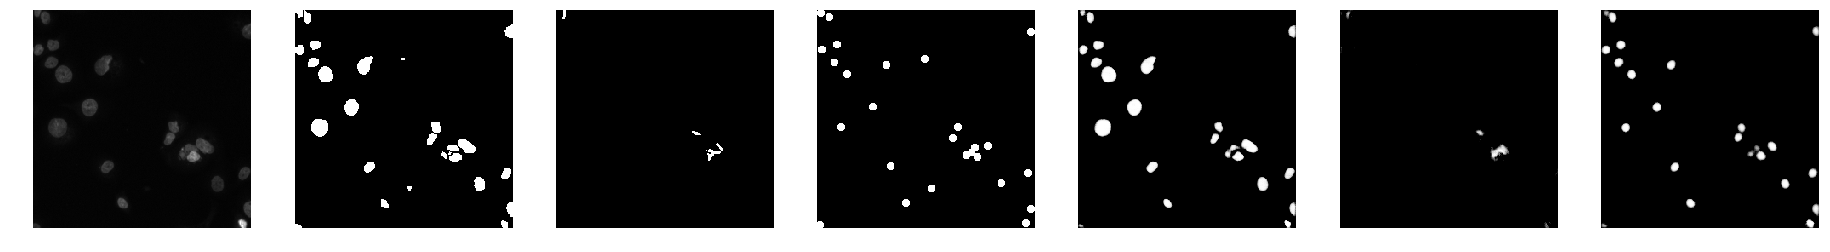

In [104]:
y_chs = [0, 1, 2]
for i in [0, 1, 2, 3, 4, 5]:
    images = []
    images += [X_pred[i, ..., 0]]
    images += [Y_true[i, ..., ch] for ch in y_chs]
    images += [Y_pred[i, ..., ch] for ch in y_chs]
    visualize.display_images(images, size=32, cols=2*len(y_chs)+1)